In [1]:
import sys
sys.path.append('/Users/Gui/Dropbox/Python_Scripts')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import scipy as sp
import scipy.stats as stats
from scipy.interpolate import interp1d

import scipy.io as scio
import scipy.stats as stats

import stats13tools.stats13tools as st
import matplotlib.ticker

from bootstrap import bootstrap_routines as boot



%matplotlib inline

In [3]:
colors = {"orange": "#f0ad4e",
          "red": "#d9534f",
          "blue": "#5bc0de",
          "green": "#5cb85c",
          "gray": "#636c72",
          "lightgray": "#d2d2d2"
         }

# P-value and sample size

In [37]:
#correct if the population S.D. is expected to be equal for the two groups.
#correct for more general case including nx !=ny
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x)-np.mean(y))/np.sqrt(((nx-1)*np.std(x, ddof=1)**2+(ny-1)*np.std(y, ddof=1)**2)/dof)

#correct only if nx=ny
def cohen_d2(x,y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def cohend_ci(d, x, y):
    n1 = len(x)
    n2 = len(y)
    t = d*np.sqrt((n1*n2)/(n1+n2))
    return t

The table below contains descriptors for magnitudes of d = 0.01 to 2.0, as initially suggested by Cohen and expanded by Sawilowsky

| Effect size   | d    | Reference        |
| ------------- |:----:| ----------------:|
| very small    | 0.01 | Sawilowsky, 2009 |
| small         | 0.20 | Cohen, 1988      |
| medium        | 0.50 | Cohen, 1988      |
| large         | 0.80 | Cohen, 1988      |
| very large    | 1.20 | Sawilowsky, 2009 |
| huge          | 2.00 | Sawilowsky, 2009 |

In [40]:
#import matlab data
mat_contents = scio.loadmat("../hentschke-paper-data/hip_thetaNegativePeakAmp.mat")
grp1,grp2 = mat_contents['d'][0][0]
grp1,grp2 = grp1.flatten(), grp2.flatten()

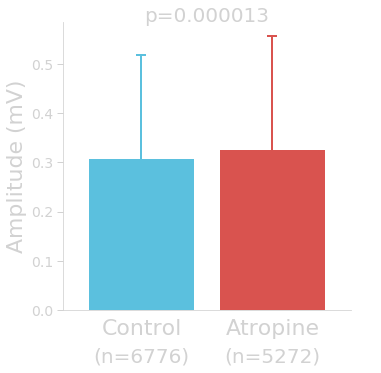

In [41]:
t,p = stats.ttest_ind(grp1,grp2, equal_var=False)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax2=ax1.twinx()
ax3=ax1.twinx()

for ax in [ax1]:
    ax.bar(np.arange(2), np.abs([grp1.mean(), grp2.mean()]), color=[colors["blue"], colors["red"]])
    for pos, y, err, color in zip(np.arange(2), np.abs([grp1.mean(), grp2.mean()]), [grp1.std(), grp2.std()], [colors["blue"], colors["red"]]):
        ax.errorbar(pos, y, err, lw=2, capsize=5, capthick=2, color=color)
 
for ax in [ax1]:
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color(colors["lightgray"])
    ax.tick_params(axis="y", width=1, size=6, labelsize=14, color=colors["lightgray"], labelcolor=colors["lightgray"])
    ax.tick_params(axis="x", width=1, size=0, color=colors["lightgray"], labelcolor=colors["lightgray"], pad=9)
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(["Control", "Atropine"], size=22, color=colors["lightgray"])
    #ax.set_ylim([0, 32])
    ax.set_ylabel("Amplitude (mV)", size=22, color=colors["lightgray"])
    ax.set_xlim(-0.6, 1.6)

for ax in [ax2]:
    ax.axis("off")
    ax.set_ylim(ax1.get_ylim())
    ax.text(0.5, ax.get_ylim()[1]*1, "p={:.6f}".format(p), size=20, color=colors["lightgray"], ha="center")
    
for ax in [ax3]:
    ax.axis("off")
    ax.set_ylim(ax1.get_ylim())
    ax.text(0, ax.get_ylim()[1]*-0.18, "(n={:.0f})".format(len(grp1)), size=20, color=colors["lightgray"], ha="center")
    ax.text(1, ax.get_ylim()[1]*-0.18, "(n={:.0f})".format(len(grp2)), size=20, color=colors["lightgray"], ha="center")

#plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/meeting/pvalue-es-sample-size-bar-data.svg", transparent=True)

In [42]:
print(len(grp1), len(grp2))

6776 5272


In [46]:
#t = d*sqrt((n1*n2)/(n1+n2))

nSample=np.concatenate([range(10,51,1),
                        range(54,201,4),
                        range(208,401,8),
                        range(420,1001,20),
                        range(1100,5001,100)])
nS=len(nSample)

result = pd.DataFrame({'pval': np.ones(nS),
                       'es': np.ones(nS),
                       'es_ci_low': np.ones(nS),
                       'es_ci_high': np.ones(nS),
                       'cohend': np.ones(nS),
                       'cohend_ci_low': np.ones(nS),
                       'cohend_ci_high': np.ones(nS)}
                     )

for i,n in enumerate(nSample):
    x = np.random.choice(grp1, size=n)
    y = np.random.choice(grp2, size=n)
    t,p = stats.ttest_ind(x,y, equal_var=False)
    es = x.mean()-y.mean()
    cohend = cohen_d(x,y)
    cohendci = [cohend_ci(cohend, x, y), cohend_ci(cohend, x, y)]
    ci = boot.bootci_diff(x,y, nboot=1000)
    result.iloc[i][['pval', 'es', 'cohend','es_ci_low', 'es_ci_high', 'cohend_ci_low', 'cohend_ci_high']] = np.concatenate([[p,es, cohend],ci,cohendci])
    
#rolling mean for pval, es and cohend. Window of n=8
nRoll = 8
result['pval_runAvg'] = result.pval.rolling(window=nRoll, center=False).mean()
result['es_runAvg'] = result.es.rolling(window=nRoll, center=False).mean()
result['cohend_runAvg'] = result.cohend.rolling(window=nRoll, center=False).mean()

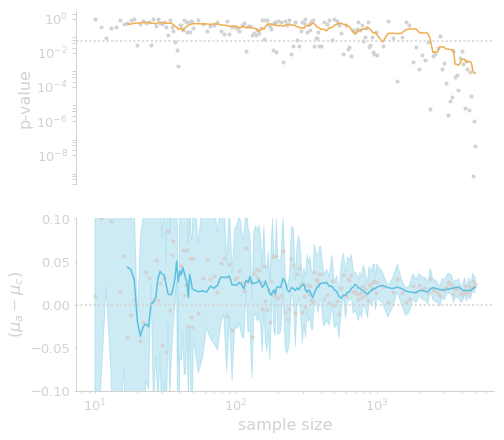

In [48]:
results1 = pd.read_csv("../hentschke-paper-data/results_analysis-1.csv")

fig,(ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 6))

ax1.plot(nSample, results1.pval, '.', color=colors["lightgray"])
ax1.plot(nSample, results1.pval_runAvg, '-', color=colors["orange"])
ax1.axhline(0.05, ls=':', color=colors["lightgray"])
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(nSample, results1.es, '.', color=colors["lightgray"])
ax2.plot(nSample, results1.es_runAvg, '-', color=colors["blue"])
ax2.fill_between(nSample, y1=results1.es_ci_low, y2=results1.es_ci_high, color=colors["blue"], alpha=0.3)
ax2.axhline(0.0, ls=':', color=colors["lightgray"])
ax2.set_xscale('log')
ax2.set_ylim(-0.1, 0.1)


for ax in [ax1]:
    for spine in ["left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis="y", width=1, which="both", size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xticks([])
    ax.tick_params(which='minor', bottom = 'off')
    #ax.axvspan(nSample[0], nSample[-1], ymin=0.83, ymax=1, color=colors["orange"], alpha=0.3)
    
for ax in [ax2]:
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis="both", width=1, which="both", size=2, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("sample size", size=16, color=colors["lightgray"])

for ax in [ax1]:
    ax.set_ylabel("p-value", size=16, color=colors["lightgray"])
    
for ax in [ax2]:
    ax.set_ylabel("($\mu_{a}-\mu_{c}$)", size=16, color=colors["lightgray"])
    
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.98, top=0.98,
                wspace=None, hspace=0.2)

#plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/meeting/pvalue-es-sample-size.svg", transparent=True)

# Food and cancer (relative risk)

In [4]:
data = pd.read_csv("data-src/food-cancer-relative-risk.csv")
data

,Wine,Tomatoes,Tea,Sugar,Salt,Potato,Pork,Onions,Olives,Milk,Lemon,Egg,Corn,Coffee,Cheese,Carrot,Butter,Bread,Beef,Bacon
0,0.389901,0.318063,0.430696,0.874397,1.032929,0.473562,1.076864,0.105956,0.267384,0.257069,0.125747,0.568557,0.524322,0.441800,0.798937,0.165997,0.599638,0.505263,0.453191,1.347871
1,0.493705,0.328536,0.441800,1.408457,1.248770,0.714943,1.184041,0.135412,0.298107,0.298107,0.165997,0.596869,0.713290,0.526754,0.819536,0.421819,0.671639,1.047371,0.945974,1.392254
2,0.619384,0.504095,0.453191,1.992955,1.614508,1.220203,1.357261,0.155223,0.421819,0.488025,0.307211,0.606617,0.735075,0.620819,0.907379,0.517092,1.089396,1.102075,1.656134,1.577575
3,0.705085,0.598252,0.547890,2.121452,2.136231,1.237264,1.464971,0.267384,0.474659,0.662377,0.559421,0.937258,0.939430,0.673195,1.096986,0.565931,1.130489,1.114901,1.951876,1.663817
4,0.777056,0.630957,0.829073,2.370688,2.181190,1.648487,1.559426,0.402740,0.671639,0.692151,0.719924,1.112324,1.354124,0.988496,1.607053,0.588639,1.184041,1.278005,2.201474,1.687080
5,0.920066,0.817641,0.935092,2.500288,3.187995,1.889652,1.566660,0.463801,0.716599,0.798937,0.968121,1.468366,1.573928,1.062015,1.750717,0.748810,1.248770,1.555822,3.225096,2.227095
6,1.130489,0.852419,0.950363,3.001836,3.331295,2.166100,2.087363,0.484649,0.787921,1.011638,1.002317,1.573928,2.006839,1.069414,1.942863,0.832919,1.488896,1.621998,3.935273,2.343415
7,1.203378,1.052230,1.148951,3.513408,3.645936,2.332594,2.196385,0.810108,0.872376,1.079359,1.023411,1.679290,2.852833,1.151613,2.131293,0.832919,2.667661,1.683180,4.605922,2.892721
8,1.206166,1.679290,4.438499,NaN,3.783463,2.506080,2.403834,2.939962,0.915818,2.454425,1.461585,1.702769,2.886035,2.006839,4.521436,1.186784,5.581278,1.710668,5.206944,7.266186
9,1.411720,NaN,5.581278,NaN,5.099618,5.231099,2.661495,NaN,0.922198,5.542664,NaN,3.440990,NaN,3.331295,NaN,NaN,NaN,3.962689,NaN,9.839314


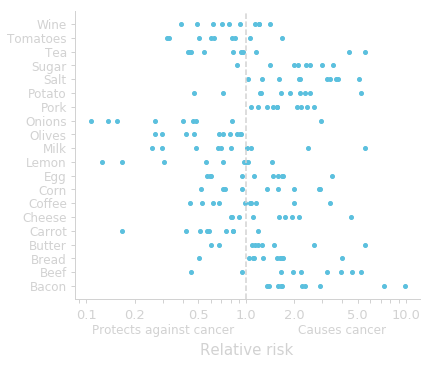

In [67]:
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.16, 0.16, 0.8, 0.8])
    
for ax in [ax1]:
    for i,food in enumerate(data.columns[::-1]):
        ax.plot(data[food], np.zeros(len(data[food]))+i, ".", ms=8, color=colors["blue"])
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.set_xscale("log")
    ax.set_xticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(x)))
    ax.set_yticks(np.arange(len(data.columns[::-1])))
    ax.set_yticklabels(data.columns[::-1])
    ax.tick_params(axis="y", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=12, pad=4)
    ax.tick_params(axis="x", width=1, which="both", size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=6)
    ax.axvline(1, ls="--", color=colors["lightgray"])
    ax.text(1, -5, "Relative risk", size=15, color=colors["lightgray"], ha="center")
    ax.text(0.3, -3.5, "Protects against cancer", size=12, color=colors["lightgray"], ha="center")
    ax.text(4, -3.5, "Causes cancer", size=12, color=colors["lightgray"], ha="center")
    #ax.set_xlabel("Cancer relative risk", size=15, color=colors["lightgray"])
    #ax.tick_params(which='minor', bottom = 'off')
    
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/food-cancer-relative-risk.svg", transparent=True)

# Type I, Type II

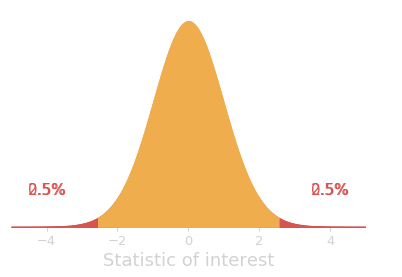

In [26]:
#t distribution
tdist = stats.t(df=50, loc=0, scale=1)
xt = np.linspace(-5, 5, 1000)
yt = tdist.pdf(xt)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
for ax in [ax1]:
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel('Statistic of interest', size=18, color=colors["lightgray"])
    ax.set_xlim(xt.min(), xt.max())
    
for ax in [ax2]:
    lower_lim = -1.96
    upper_lim = 1.96
    ax.fill_between(xt[(xt>lower_lim) & (xt<upper_lim)], yt[(xt>lower_lim) & (xt<upper_lim)],
                       color=colors["orange"], alpha=1)
    ax.fill_between(xt[(xt<=lower_lim)], yt[(xt<=lower_lim)],
                       color=colors["red"], alpha=1)
    ax.fill_between(xt[(xt>=upper_lim)], yt[(xt>=upper_lim)],
                       color=colors["red"], alpha=1)
    for x in [-4, 4]:
        ax.text(x, ax.get_ylim()[1]*0.15, "2.5%", color=colors["red"], size=15, ha="center")
    ax.set_ylim(0)
    ax.axis("off")
    
for ax in [ax3]:
    lower_lim = -2.576
    upper_lim = 2.576
    ax.fill_between(xt[(xt>lower_lim) & (xt<upper_lim)], yt[(xt>lower_lim) & (xt<upper_lim)],
                       color=colors["orange"], alpha=1)
    ax.fill_between(xt[(xt<=lower_lim)], yt[(xt<=lower_lim)],
                       color=colors["red"], alpha=1)
    ax.fill_between(xt[(xt>=upper_lim)], yt[(xt>=upper_lim)],
                       color=colors["red"], alpha=1)
    for x in [-4, 4]:
        ax.text(x, ax.get_ylim()[1]*0.15, "0.5%", color=colors["red"], size=15, ha="center")
    ax.set_ylim(0)
    ax.axis("off")


plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/type1-error-probability.svg", transparent=True)

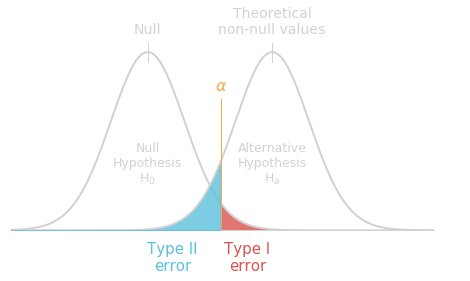

In [96]:
#t distribution
xt = np.linspace(-5.5, 11.5, 1000)
tdist_null = stats.t(df=50, loc=0, scale=1.5)
yt_null = tdist_null.pdf(xt)
tdist_alt = stats.t(df=50, loc=5, scale=1.5)
yt_alt = tdist_alt.pdf(xt)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.01, 0.15, 0.98, 0.65])
ax2 = ax1.twinx()
    
for ax in [ax1]:
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    #ax.tick_params(axis="both", width=1, size=0, color=colors["lightgray"], labelcolor=colors["lightgray"], 
    #               labelsize=13, pad=4)
    ax.set_xlim(xt.min(), xt.max())
    upper_lim = 1.96*1.5
    ax.plot(xt, yt_null, color=colors["lightgray"], alpha=1, lw=2)
    ax.fill_between(xt[(xt>=upper_lim)], yt_null[(xt>=upper_lim)], color=colors["red"], alpha=0.8)
    ax.set_ylim(0)
    ax.text(1, -0.06, "Type II\nerror", color=colors["blue"], size=15, ha="center")
    ax.text(4., -0.06, "Type I\nerror", color=colors["red"], size=15, ha="center")
    ax.text(0., 0.07, "Null\nHypothesis\nH$_0$", color=colors["lightgray"], size=12.5, ha="center")
    ax.text(5., 0.07, "Alternative\nHypothesis\nH$_a$", color=colors["lightgray"], size=12.5, ha="center")
    

    
for ax in [ax2]:
    lower_lim = 1.96*1.5
    ax.plot(xt, yt_alt, color=colors["lightgray"], alpha=1, lw=2)
    ax.fill_between(xt[(xt<=lower_lim)], yt_alt[(xt<=lower_lim)],
                       color=colors["blue"], alpha=0.8)
    ax.axvline(lower_lim, ymax=0.7, color=colors["orange"], lw=1)
    ax.text(lower_lim, ax.get_ylim()[1]*0.75, r"$\alpha$", color=colors["orange"], size=16, ha="center")
    ax.axvline(0, ymin=0.9, ymax=1, color=colors["lightgray"], lw=1)
    ax.text(0, ax.get_ylim()[1]*1.05, "Null", color=colors["lightgray"], size=14, ha="center")
    ax.axvline(5, ymin=0.9, ymax=1, color=colors["lightgray"], lw=1)
    ax.text(5, ax.get_ylim()[1]*1.05, "Theoretical\nnon-null values", color=colors["lightgray"], size=14, ha="center")
    ax.set_ylim(0)
    ax.axis("off")


plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/type1-type2-error-trade-off.svg", transparent=True)